In [1]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
import json
import joblib as joblib

import re
import string

In [2]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [3]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_70_30.csv')
data_val = pd.read_csv('../../Data Splits/val_data_70_30.csv')

In [4]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [5]:
# Stopword Removal
ps = PorterStemmer()
with open('../../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

# Custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join(self.preprocess(text)) for text in X]
    
    def preprocess(self, text):
        # Lowercase Conversion
        lowered = text.lower()

        # URL Removal
        urled = re.sub(r'https?://\S+|www\.\S+', '', lowered)
        
        # Text Simplification
        text = re.sub(r'\[.*?\]', '', urled)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)

        # Tokenization
        tokens = nltk.word_tokenize(text)
        stems = [ps.stem(token) for token in tokens]
        filtered = [stem for stem in stems if stem not in stopwords]
        return filtered

In [6]:
#create StopWords
stopwords = pd.read_json('../../Datasets/stopwords-tl.json')
custom_stop_words = stopwords[0].values.tolist()

In [7]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

# Define the parameter grid
param_grid = {'penalty': ['l2'], 'C': [1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear']}

In [8]:
# Define the steps in your pipeline
steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer(stop_words=custom_stop_words)),
    ('gridsearch', GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1))

]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['akin', 'aking', 'ako', 'alin',
                                             'am', 'amin', 'aming', 'ang',
                                             'ano', 'anumang', 'apat', 'at',
                                             'atin', 'ating', 'ay', 'bababa',
                                             'bago', 'bakit', 'bawat', 'bilang',
                                             'dahil', 'dalawa', 'dapat', 'din',
                                             'dito', 'doon', 'gagawin',
                                             'gayunman', 'ginagawa', 'ginawa', ...])),
                ('gridsearch',
                 GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                              param_grid={'C': [1, 10, 100, 1000],
                                          'penalty': ['l2'],
                                          'solver': ['lbfgs', 'liblinear']},
                              scoring='accuracy'))])

In [9]:
best_meta = pipeline.named_steps['gridsearch'].best_estimator_
joblib.dump(pipeline.named_steps['gridsearch'] , '../../ModelsV2/pipeline_lr_gridsearch.joblib')


['../../ModelsV2/pipeline_lr_gridsearch.joblib']

In [10]:
print("Best Hyperparameters: ", pipeline.named_steps['gridsearch'].best_params_)
print("Best Accuracy: {:.2f}%".format(pipeline.named_steps['gridsearch'].best_score_ * 100))

Best Hyperparameters:  {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy: 94.77%


In [11]:

steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer(stop_words=custom_stop_words)),
    ('stacking', StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta ,cv=5))
    ]
stack = Pipeline(steps)
stack.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['akin', 'aking', 'ako', 'alin',
                                             'am', 'amin', 'aming', 'ang',
                                             'ano', 'anumang', 'apat', 'at',
                                             'atin', 'ating', 'ay', 'bababa',
                                             'bago', 'bakit', 'bawat', 'bilang',
                                             'dahil', 'dalawa', 'dapat', 'din',
                                             'dito', 'doon', 'gagawin',
                                             'gayunman', 'ginagawa', 'ginawa', ...])),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('MNB', MultinomialNB()),
                                                ('LR', LogisticRegression()),
                                                ('RF',
                                                 RandomForestClassifier()),
                                                ('KNN', KNeighborsClassifier()),
                                                ('SVM', SVC(probability=True))],
                                    final_estimator=LogisticRegression(C=100,
                                                                       solver='liblinear')))])

Metrics for MNB:
Accuracy: 0.8201970443349754
Precision: 0.7416974169741697
Recall: 0.9852941176470589
F1 Score: 0.8463157894736842
AUC: 0.9751019219569016
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       404
           1       0.74      0.99      0.85       408

    accuracy                           0.82       812
   macro avg       0.86      0.82      0.81       812
weighted avg       0.86      0.82      0.82       812



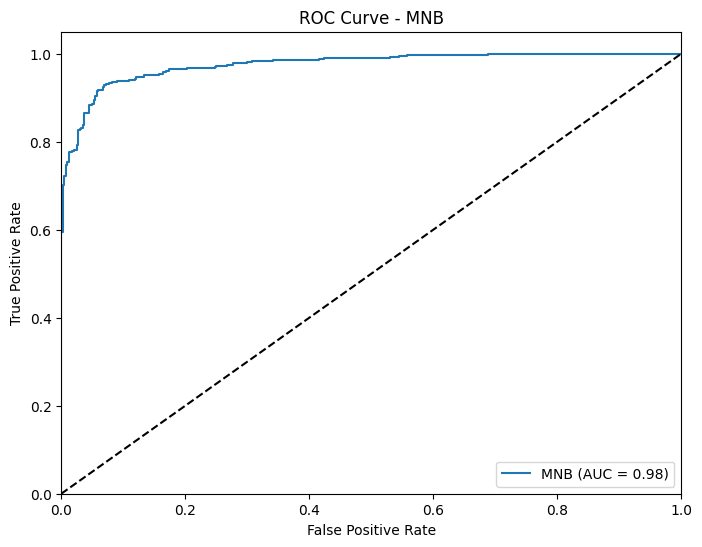

Metrics for LR:
Accuracy: 0.9174876847290641
Precision: 0.962059620596206
Recall: 0.8700980392156863
F1 Score: 0.9137709137709138
AUC: 0.9793122694622404
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       404
           1       0.96      0.87      0.91       408

    accuracy                           0.92       812
   macro avg       0.92      0.92      0.92       812
weighted avg       0.92      0.92      0.92       812



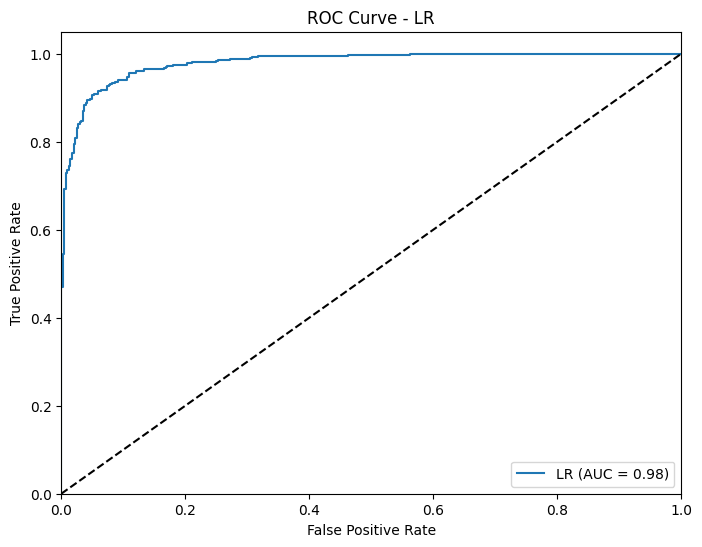

Metrics for RF:
Accuracy: 0.916256157635468
Precision: 0.9521276595744681
Recall: 0.8774509803921569
F1 Score: 0.9132653061224489
AUC: 0.9752262910114541
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       404
           1       0.95      0.88      0.91       408

    accuracy                           0.92       812
   macro avg       0.92      0.92      0.92       812
weighted avg       0.92      0.92      0.92       812



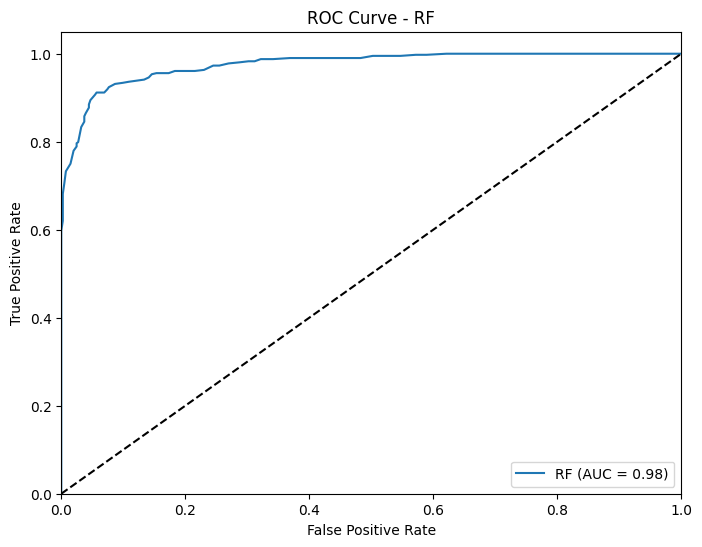

Metrics for KNN:
Accuracy: 0.8620689655172413
Precision: 0.8162393162393162
Recall: 0.9362745098039216
F1 Score: 0.8721461187214612
AUC: 0.9349216171617161
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       404
           1       0.82      0.94      0.87       408

    accuracy                           0.86       812
   macro avg       0.87      0.86      0.86       812
weighted avg       0.87      0.86      0.86       812



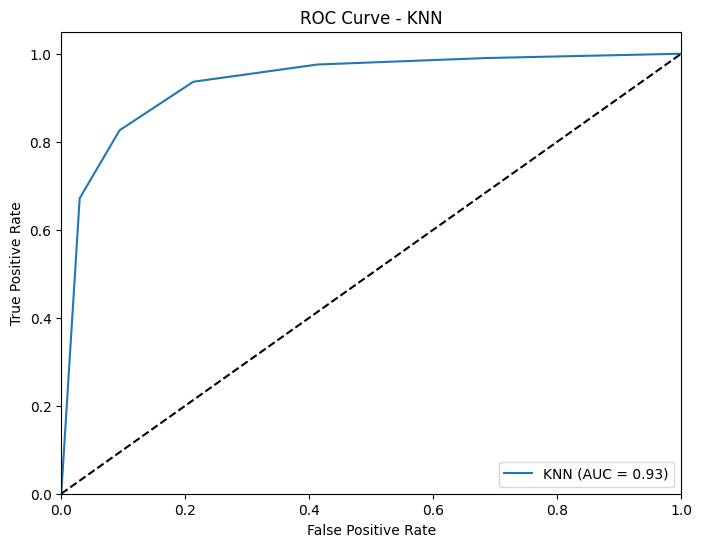

Metrics for SVM:
Accuracy: 0.9199507389162561
Precision: 0.9673024523160763
Recall: 0.8700980392156863
F1 Score: 0.9161290322580645
AUC: 0.9836803533294505
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       404
           1       0.97      0.87      0.92       408

    accuracy                           0.92       812
   macro avg       0.92      0.92      0.92       812
weighted avg       0.92      0.92      0.92       812



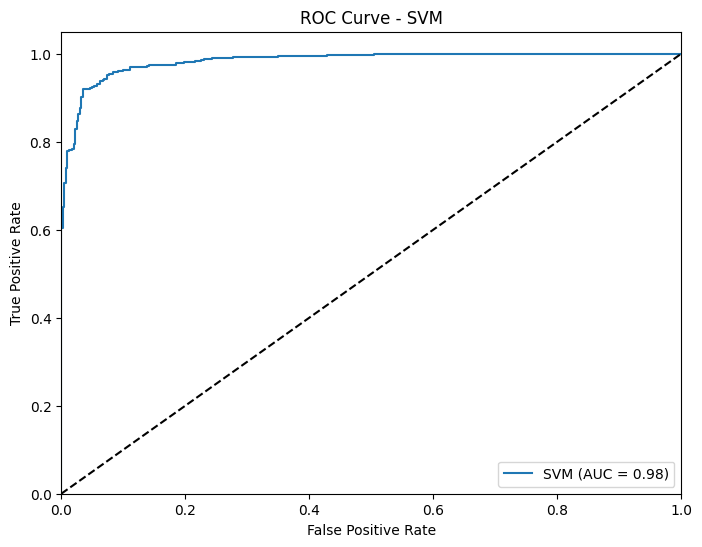

In [12]:


# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Use TFIDF inside of stacking to vectorize X_val(Evaluation)
vectorized_text = stack.named_steps['vectorizer'].transform(X_val)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9568965517241379
Precision: 0.9604938271604938
Recall: 0.9534313725490197
F1 Score: 0.956949569495695
AUC: 0.9925985245583381
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       404
           1       0.96      0.95      0.96       408

    accuracy                           0.96       812
   macro avg       0.96      0.96      0.96       812
weighted avg       0.96      0.96      0.96       812



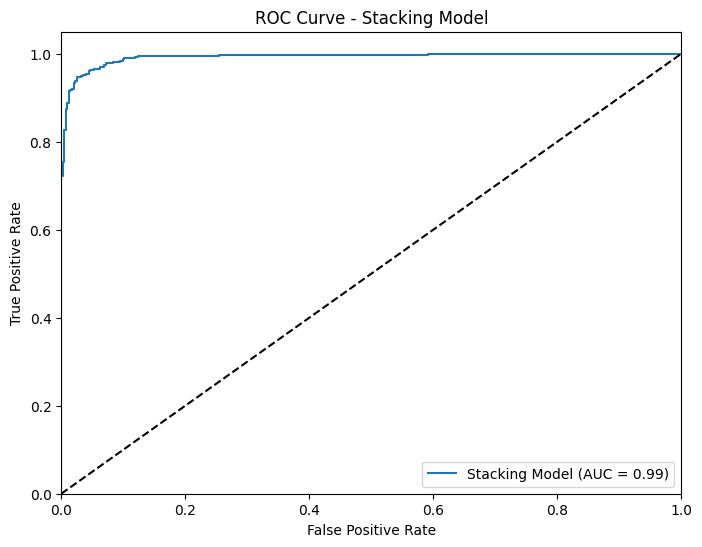

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.820197  0.741697  0.985294  0.846316  0.975102
LR              0.917488   0.96206  0.870098  0.913771  0.979312
RF              0.916256  0.952128  0.877451  0.913265  0.975226
KNN             0.862069  0.816239  0.936275  0.872146  0.934922
SVM             0.919951  0.967302  0.870098  0.916129   0.98368
Stacking Model  0.956897  0.960494  0.953431   0.95695  0.992599


In [13]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val)
stack_y_prob = stack.predict_proba(X_val)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [14]:
# Save the model using joblib
joblib.dump(stack, '../../ModelsV2/pipeline_lr.joblib')

['../../ModelsV2/pipeline_lr.joblib']